In [30]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
from termcolor import colored                     # coloration du texte
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
from pyextremes import EVA                        # valeurs extrêmes  
from tabulate import tabulate                     # impression du texte dans un format tabulé
plt.rcParams['text.usetex'] = True                # paramètres latex
#plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
# plt.rcParams.update({
#     "text.usetex": True,
#     #"font.family": "Times New Roman",
#     "font.family": "Libertine",
#     "font.size": 12
# })

plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Times New Roman",
    "font.family": "Linux Libertine",
    "font.size": 12
})
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#plt.style.use('default')

import arviz as az
import pymc as pm
import pymc_experimental.distributions as pmx
import pytensor.tensor as pt
from arviz.plots import plot_utils as azpu

from os.path import expanduser
base = expanduser("~")
from IPython.display import display, Math, Latex

################################
## Auteur : Christoophe Ancey ##
## Date : octobre 2024        ##
################################



def LVE_cdf(x,m,a,xi):
    if xi < 0:
        if x < m-a/xi:
            cdf = np.exp(-(1 + (-m + x)*xi/a)**(-1/xi))
        else:
            cdf = 1
    elif xi>0:
        if x > m-a/xi:
            cdf = np.exp(-(1 + (-m + x)*xi/a)**(-1/xi))
        else:
            cdf = 0
    else:
        cdf = np.exp(-np.exp(-(x-m)/a))
    return cdf

def LVE_pdf(x,m,a,xi):
    if xi < 0:
        if x < m-a/xi:
            aux = (np.exp(((-(1.+(((x-m)*xi)/a))**(-1./xi)))))*((1.+(((x-m)*xi)/a))**((-1.-xi)/xi))
            pdf = aux/a 
        else:
            pdf = 0
    elif xi>0:
        if x > m-a/xi:
            aux = (np.exp(((-(1.+(((x-m)*xi)/a))**(-1./xi)))))*((1.+(((x-m)*xi)/a))**((-1.-xi)/xi))
            pdf = aux/a 
        else:
            pdf = 0
    else:
        pdf = (np.exp((((m-x)/a)-(np.exp(((m-x)/a))))))/a
    return pdf

def LVE_quantile(T,mu,sigma,xi):
    if xi != 0:
        quant = mu-sigma/xi*(1-(-np.log(1-1/T))**(-xi))
    else:
        quant = mu-sigma *np.log(-np.log(1-1/T) )
    return quant

In [61]:
def tracer_résultats(i,ax, mu, sigma, xi):

      nom_figure = ['(a)','(b)','(c)','(d)']
      if xi>0:
            nom_loi = 'Fréchet'
      else:
            nom_loi = 'Weibull'
      intervalle = np.linspace(-4,4,1000)

      ax.set_xlabel(r"$X$ ")
      ax.set_ylabel(r"$P(x)$  ")
      ax.grid()
      ax.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
      ax.yaxis.set_minor_locator(AutoMinorLocator(5))
      ax.tick_params(which='major', length=7)
      ax.tick_params(which='minor', length=4)
      plt.xscale('symlog', linthresh=1 )
      cdf = [LVE_cdf(x, mu, sigma, xi) for x in intervalle]
      pdf = [LVE_pdf(x, mu, sigma, xi) for x in intervalle]


      
      ax.plot(intervalle,cdf,'-', color='black', label = "prob")
    
      ax.plot(intervalle,pdf,'--',color='red'  , label = "ddp")

      if i == 0:
            ax.legend(loc="center left",ncol=1,frameon=False)
       
      ax.text(0.1, 0.9,  nom_figure[i],
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,fontsize=14)
      
def tracer_quantile(i,ax,mu,sigma):
       
      nom_figure = '(d)'
      période = np.linspace(1.1,100,1000)

      ax.set_xlabel(r"$T$ ")
      ax.set_ylabel(r"$X$  ")
      ax.grid()
      ax.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
      ax.yaxis.set_minor_locator(AutoMinorLocator(5))
      ax.tick_params(which='major', length=7)
      ax.tick_params(which='minor', length=4)
      plt.xscale('symlog', linthresh=1 )


 
      ax.semilogx(période,LVE_quantile(période,mu, sigma, 0),'--',color='black' , label = "loi de Gumbel")
      ax.semilogx(période,LVE_quantile(période,mu, sigma, -.5),'-.',color='orange' , label = "loi de Weibull")
      ax.semilogx(période,LVE_quantile(période,mu, sigma, .5),'-',color='red' , label = "loi de Fréchet")

      
      ax.legend(loc="upper center",ncol=1,frameon=False)
       
      ax.text(0.1, 0.9,  nom_figure,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,fontsize=14)

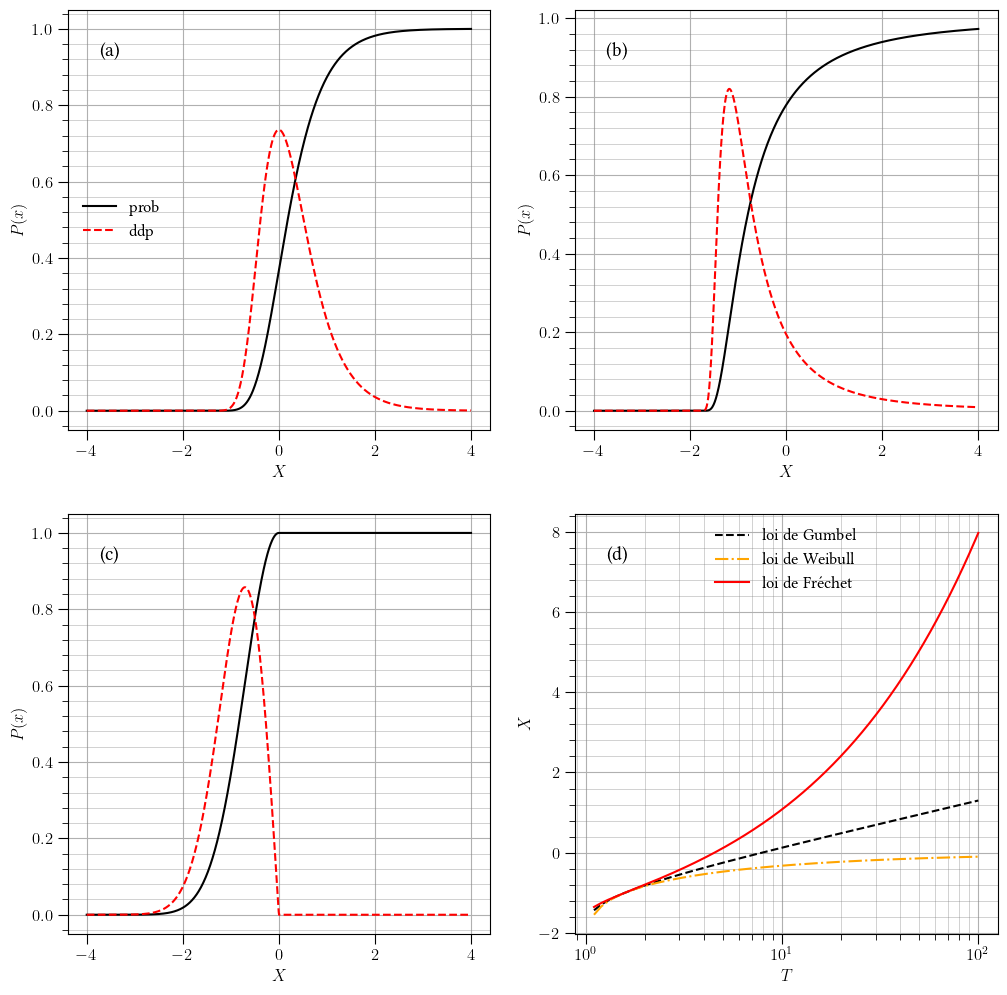

In [62]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(12)

tracer_résultats(0,ax0,0,0.5,0)
tracer_résultats(1,ax1,-1,0.5,0.5)
tracer_résultats(2,ax2,-1,0.5,-0.5)
tracer_quantile(3,ax3,-1,0.5)

In [63]:
fig.savefig('LVE_figure.png',dpi=300,bbox_inches='tight')